In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from tqdm import tqdm
import emcee
import corner
import pymultinest
import json
import getdist
from getdist import plots, MCSamples
import os

#!/usr/bin/env python
from __future__ import absolute_import, unicode_literals, print_function
try: os.mkdir('chains')
except OSError: pass

Create the complicated function as mentioned:

In [2]:
def log_likelihood(params, a=8, b=4.5, c=3):
    """
    Negative Log-likelihood function defined below, with the dark energy, dark matter parameters
    
    param params: tuple of 2 numbers x, y
    """
    x, y = params  # params is tuple of 2 numbers
    # Define some complicated function as our log-likelihood

    log_likelihood = -(1/((1 + np.exp(a*(x - b))) * (1 + np.exp(-a*(x + b)))) + np.exp(y/c))
    
    return np.min([-1.1, log_likelihood]) # hacky way to make the likelihood always positive

    # return log_likelihood

Test to make sure the function is actually being plotted as suggested:

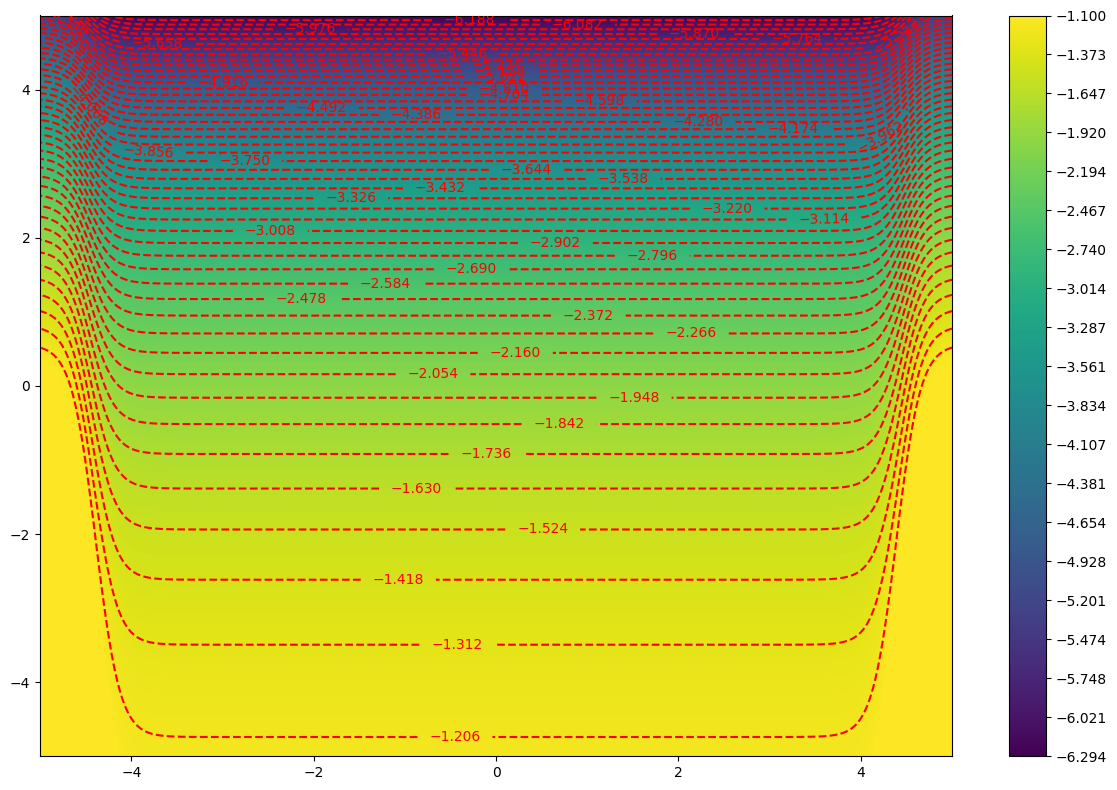

In [3]:
npoints = 500

# bounds of our sampling
x_lower = -5
x_upper = 5
y_lower = -5
y_upper = 5

testarr = np.zeros((npoints, npoints))
X, Y = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints))

for i in range(0, len(X)):
    for j in range(0, len(Y)):
        testarr[i, j] = log_likelihood((X[i, j], Y[i, j]))  # log likelihood

# min and max for the contours
contour_min = np.min(testarr)
contour_max = np.max(testarr)

# plot

plt.figure(figsize = (12, 8))
plt.contourf(X, Y, testarr, levels=np.linspace(contour_min, contour_max, npoints), cmap='viridis')
cb = plt.colorbar()
# cb.formatter = LogFormatterExponent(base=10)
# this goes from ~ -50 to 0
cb.set_ticks(np.linspace(contour_min, contour_max, 20))#, update_ticks=True)

fig = plt.contour(X, Y, testarr, levels=np.linspace(contour_min, contour_max, 50), colors='r')

plt.clabel(fig, inline=True, fontsize=10)
plt.tight_layout()
plt.savefig('2d_u_function_likelihood_modified.png')#, fmt='png')
plt.show()

Now, try sampling the function using MCMC and nested sampling:

## MCMC:

Define a log prior and a log probability:

In [4]:
x_lower, x_upper = (-5, 5)  # -5, 5 cube
y_lower, y_upper = (-5, 5)

def mcmc_log_prior(params, x_min=x_lower, x_max=x_upper, y_min=y_lower, y_max=y_upper):
    """
    Log prior that is uniform over x = (-5, 5), y = (-5, 5) and 0 outside of that range
    """
    # params are x and y
    x, y = params
    # if they fall within [-5, 5], [-5, 5] uniform prior, otherwise 0 outside that range
    if (x_min <= x <= x_max and y_min <= y <= y_max):
        return 0.  # log prior, so ln(1) = 0
    else:
        return -np.inf  # log prior, so ln(0) = -infinity
    

def mcmc_log_probability(params):
    # get the log prior for the params
    lp = mcmc_log_prior(params)
    # negative infinity (log(0)) if outside [-5, 5], [-5, 5], as detected by the log prior
    if not np.isfinite(lp):
        return -np.inf
    # otherwise, log prob is log prior + log likelihood
    return lp + log_likelihood(params) 

Now set up the MCMC (use $50$ walkers with $50000$ steps) to check. The starting position of our walkers is drawn from a small Gaussian distribution ($\sigma = 0.01$) around $[0, -5]$ (the bottom of the plot):

In [5]:
nwalkers = 50  # nubmer of walkers to use in the MCMC
ndim = 2  # 2 dimensions for our rosenbrock function
seed = 1234  # seed to use for picking a random point
nsteps = 50000  # number of mcmc steps to take

# choose two starting positions at (+-4.5, -4.5) 
# and see if the chains are still well-mixed
left_pos = [-4.5, -4.5]
right_pos = [4.5, -4.5]
np.random.seed(seed)  # set the seed

left_pos = np.random.multivariate_normal(left_pos, cov = np.diag([0.01, 0.01], k=0), size = nwalkers//2)
right_pos = np.random.multivariate_normal(right_pos, cov = np.diag([0.01, 0.01], k=0), size=nwalkers//2)
pos = np.concatenate((left_pos, right_pos))

# pos = np.random.multivariate_normal(starting_pos, cov = np.diag([0.01, 0.01], k=0), size = nwalkers)  # Gaussian ball, 0.01 chosen arbitrarily
# pos = np.random.uniform([x_lower, y_lower], [x_upper, y_upper], size=(nwalkers, ndim))  # choose n random points uniformly

# setting up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_log_probability)

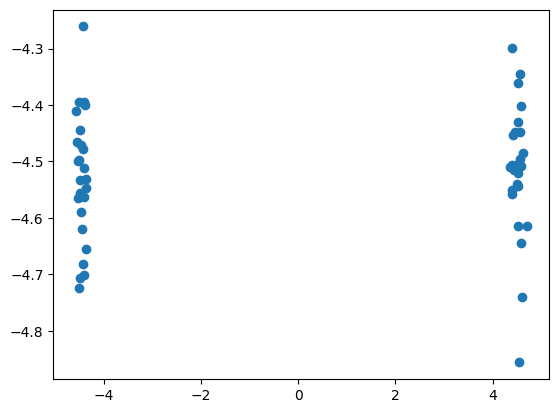

In [6]:
plt.scatter(pos[:,0], pos[:,1])
plt.show()

And run the sampler:

In [7]:
sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 50000/50000 [01:12<00:00, 691.42it/s]


State([[ 3.12886706e+00 -9.87939783e-01]
 [ 5.34168295e-01 -4.73645425e+00]
 [ 1.14494727e+00 -2.05476659e+00]
 [ 1.00720901e-01 -4.25179588e+00]
 [ 3.17298170e-01 -4.02963941e+00]
 [ 4.53914456e-01 -3.25531126e+00]
 [ 4.87590177e+00 -3.19756076e+00]
 [-4.98064817e+00 -2.99649086e+00]
 [-3.35732881e+00  5.86865800e-01]
 [ 4.30529063e+00 -4.92455455e+00]
 [ 7.23385039e-02 -4.32269145e+00]
 [-4.57927014e+00 -3.90179628e+00]
 [-4.00670720e+00 -2.27682272e+00]
 [ 2.06581748e+00  1.16709544e+00]
 [-8.54218630e-01 -3.86006050e+00]
 [-1.16763812e+00 -2.90799240e+00]
 [ 4.71852943e+00 -2.85077287e+00]
 [ 9.42618951e-01 -4.16723068e+00]
 [ 2.41757792e+00 -3.85326770e+00]
 [-4.25337383e+00 -3.35097726e-01]
 [ 2.63819087e+00 -3.45145389e+00]
 [ 1.00328223e+00 -8.39926662e-01]
 [ 2.23449415e+00 -2.50659836e+00]
 [ 1.63177835e+00  1.14573400e+00]
 [-2.96411810e-01 -2.71891728e-01]
 [ 4.85638058e+00 -1.65028593e+00]
 [ 4.21334909e-02  1.23435796e+00]
 [ 3.86325786e+00 -4.95136940e+00]
 [-3.70869710e

Get the samples as a chain:

In [8]:
burnin = 200  # number of burn in samples to discard

samples = sampler.get_chain()[burnin:]  # discard the first 200 samples ("burn-in" time for the chains to be well-mixed)
# split into x and y samples
x_samples = samples[:, :, 0]
y_samples = samples[:, :, 1]

2D histogram of the sampled distribution:

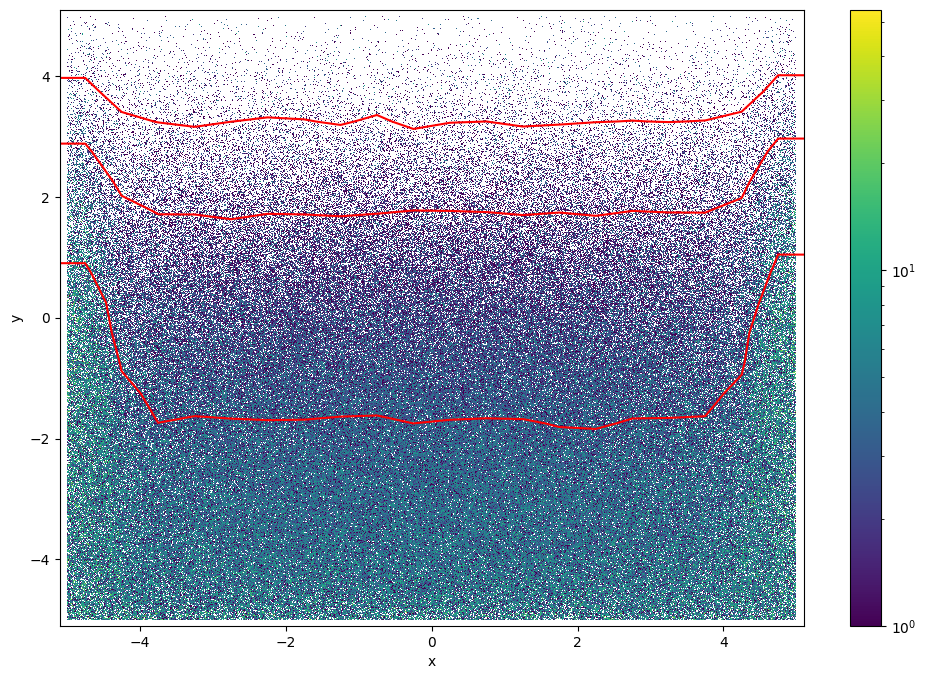

In [9]:
plt.figure(figsize = (12, 8))
corner.hist2d(x_samples.reshape(-1), y_samples.reshape(-1), s=0.1, 
              plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r')
plt.hist2d(x_samples.reshape(-1), y_samples.reshape(-1), norm = LogNorm(), bins=1000)
plt.xlabel('x'), plt.ylabel('y')
plt.xlim(left=-5.1, right=5.1)
plt.ylim(top=5.1, bottom=-5.1)
cb = plt.colorbar()
plt.savefig('mcmc_2d_function.png')#, fmt='png')
plt.show()

Plot to see if the chains are well-mixed:

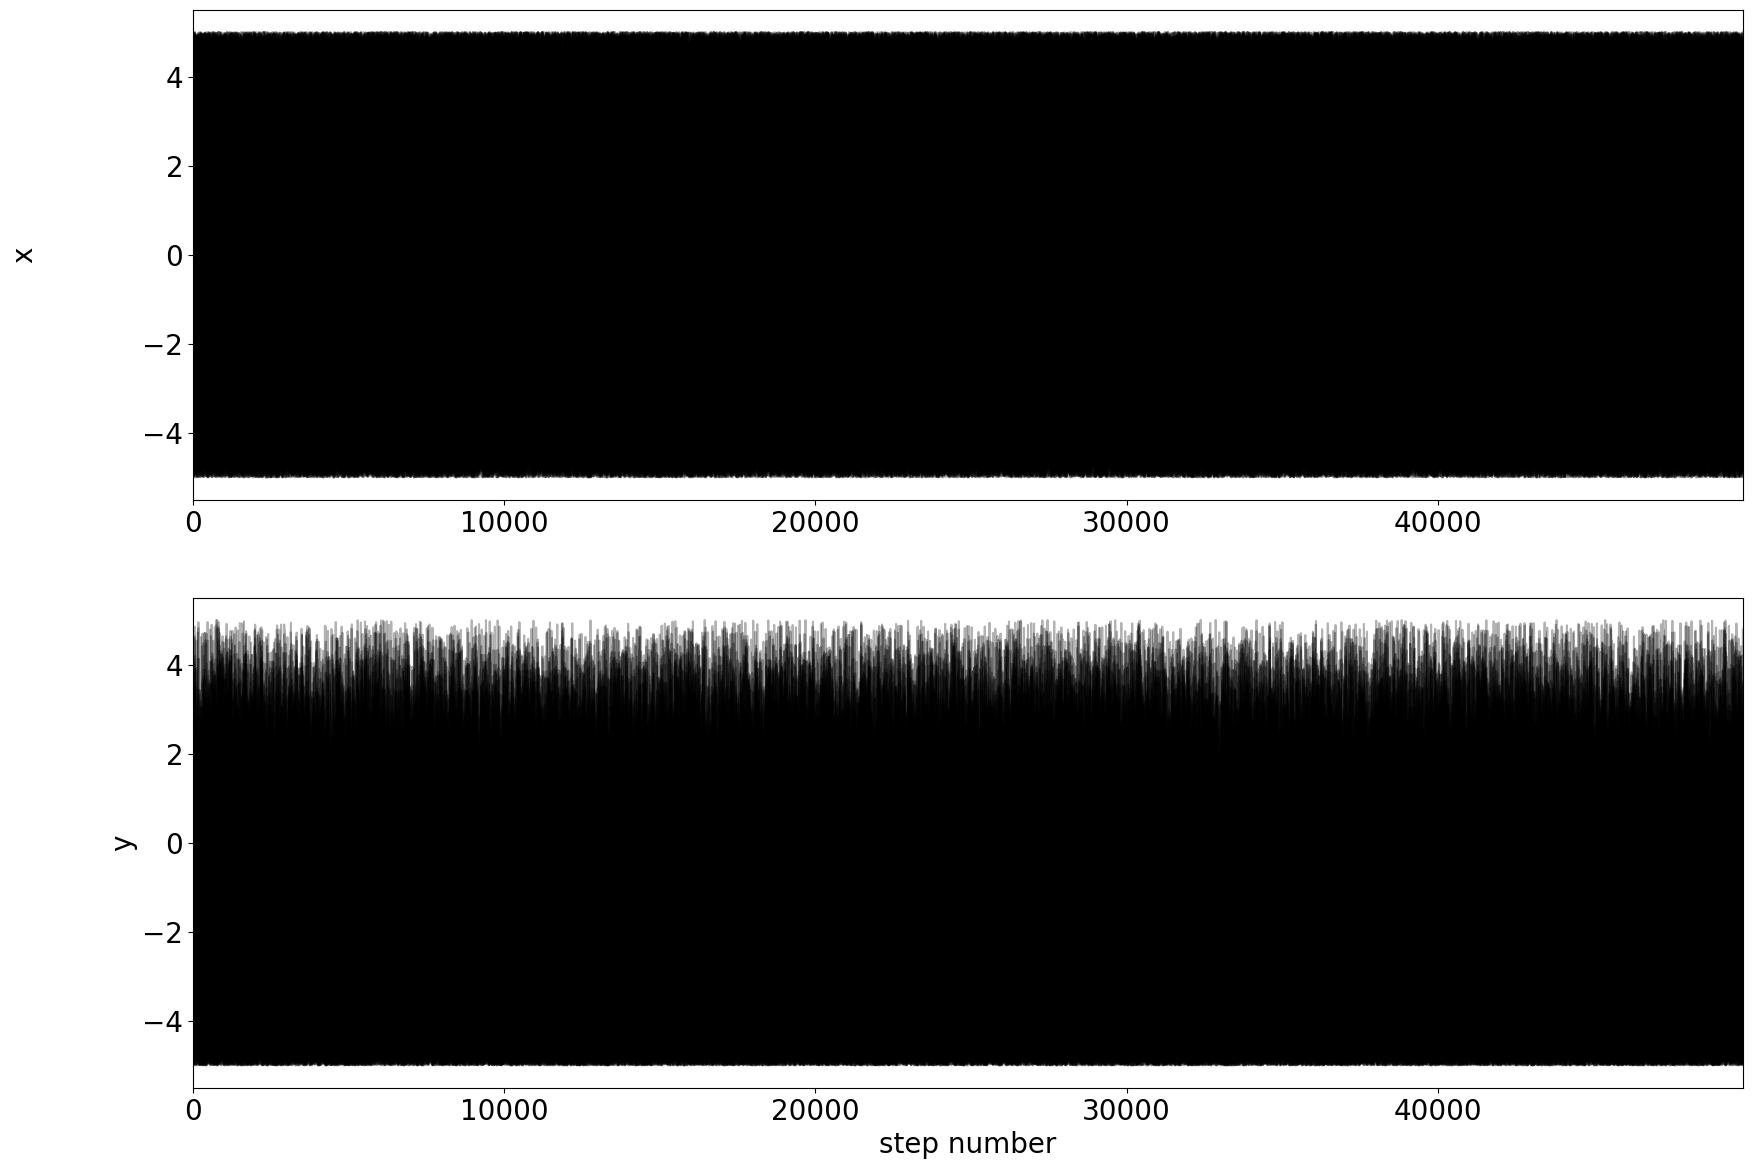

In [10]:
plt.rc('font', size=20)
_, ax = plt.subplots(2, figsize = (20, 14))
# plot the chains for x
ax[0].plot(x_samples, color='k', alpha=0.3)
ax[0].set_xlim(0, len(x_samples))
ax[0].set_ylabel('x')
ax[0].yaxis.set_label_coords(-0.1, 0.5)
# plot the chains for y
ax[1].plot(y_samples, color='k', alpha=0.3)
ax[1].set_xlim(0, len(y_samples))
ax[1].set_ylabel('y')
# ax[1].yaxis.set_label_coords(-0.1, 0.5)
# set shared x label
ax[1].set_xlabel('step number')
plt.savefig('u_plot_chains.png')#, fmt='png')
plt.show()

Generate autocorrelation plots:

In [11]:
from numpy.fft import fft, ifft, fftshift

def autocorrelation(x, dt=1):
    """
    computes the autocorrelation of 1d array [x0, x1, ..., xn]
    
    dt is the sampling time (default 1 since each step is 1)
    """
    n = 2 ** (len(x) - 1).bit_length() # n is the length to pad the FFT to (next highest power of 2 for a given chain's length 
    # compute autocorrelation
    autocorr = ifft(np.conj(fft(x, n=n) * dt) * fft(x, n=n) * 1).real[:len(x)]/(4 * n)
    return autocorr
    

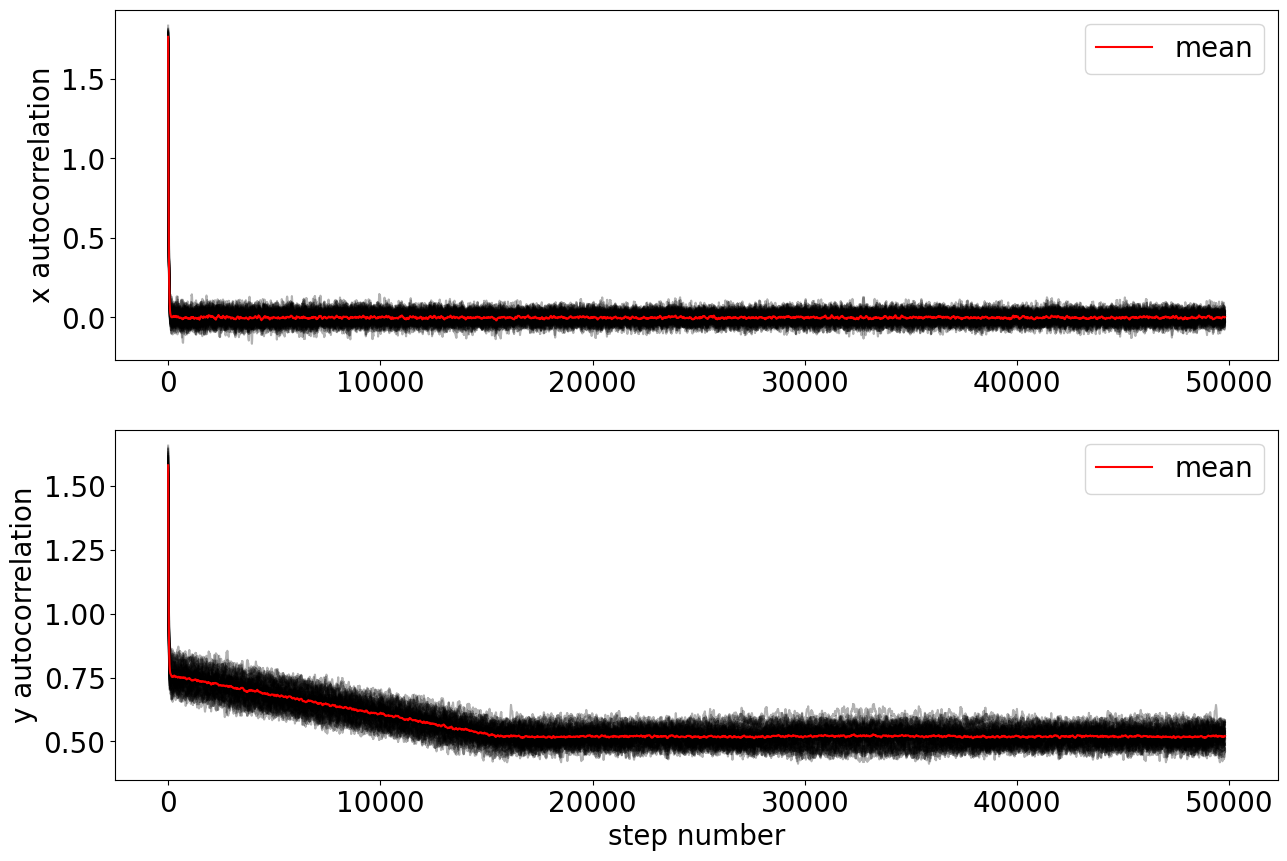

In [12]:
_, ax = plt.subplots(2, figsize = (15, 10))
# autocorrelation for x
# all chains
for i in range(0, len(y_samples.T)):
    ax[0].plot(autocorrelation(x_samples[:,i]), color='k', alpha=0.3)
# mean
ax[0].plot(np.mean(np.array([autocorrelation(x_samples[:,i]) for i in range(0, len(x_samples.T))]), axis=0), color='r', label = 'mean')
# ax[0].set_xlim(0, len(x_samples))
ax[0].set_ylabel('x autocorrelation')
ax[0].legend(loc='upper right')

# autocorrelation for y
# all chains
for i in range(0, len(y_samples.T)):
    ax[1].plot(autocorrelation(y_samples[:,i]), color='k', alpha=0.3)
# mean
ax[1].plot(np.mean(np.array([autocorrelation(y_samples[:,i]) for i in range(0, len(y_samples.T))]), axis=0), color='r', label = 'mean')
# ax[1].set_xlim(0, len(y_samples))
ax[1].set_ylabel('y autocorrelation')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('step number')
plt.show()

Defining functions to compute the autocorrelation time $\tau$, taken from the `emcee` docs:

In [13]:
# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_new(x, c=5.0):
    # empty list of walkers to average over
    f = np.zeros(len(x.T))
    # compute autocorrelation for each chain, then add all the autocorrelations together
    for xx in x:
        f += autocorrelation(xx)
    f /= len(x)
    
    # try this?
#     tau = 2 * np.sum(f) - 1.0
#     return tau
    
    # ORIGINAL
    
    # what?
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

    # return np.min(taus)

Computing autocorrelation times:

In [14]:
# Compute the estimators for a few different chain lengths
N = 50
# chain legnths
chain_sizes = (10 ** np.linspace(1, 6, N)).astype(np.int64)

x_autocorrs = np.zeros(len(chain_sizes))
y_autocorrs = np.zeros(len(chain_sizes))

for i, n in enumerate(chain_sizes):
    x_autocorrs[i] = autocorr_new(x_samples[:n, :])
    y_autocorrs[i] = autocorr_new(y_samples[:n, :])
    

Plotting the autocorrelation times for $x$ and $y$ for different chain lengths:

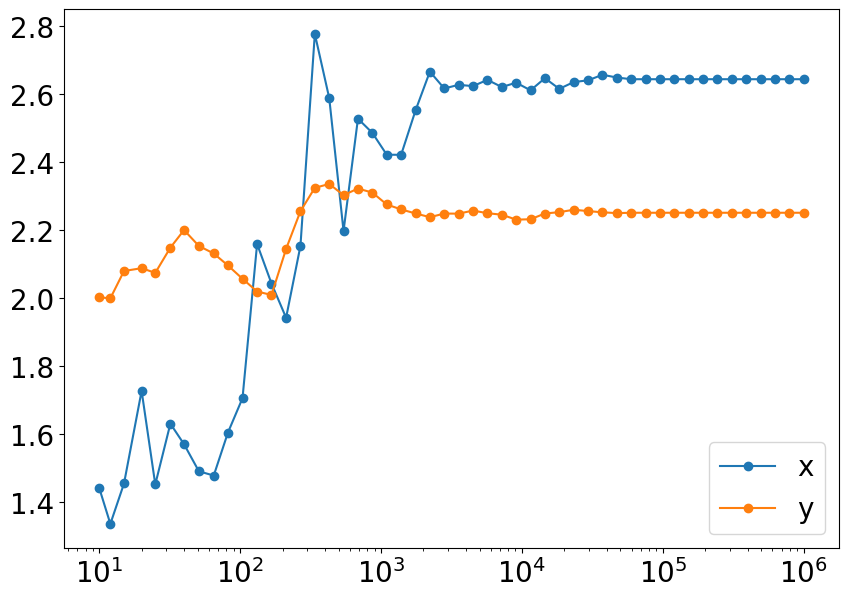

In [15]:
plt.figure(figsize = (10, 7))
# plot the autocorrelations
plt.plot(chain_sizes, x_autocorrs, '-o', label = 'x')
plt.plot(chain_sizes, y_autocorrs, '-o', label = 'y')
# set xscale log
plt.xscale('log')# , plt.yscale('log')
# legend
plt.legend(loc = 'lower right')
plt.show()

In [16]:
raw_samples = sampler.get_chain()[burnin:]

emcee.autocorr.integrated_time(raw_samples)

array([48.08903413, 43.82645612])

In [17]:
Ntimes = 20

integrated_times = np.zeros((Ntimes, 2))
chain_lengths = np.linspace(int(1e4), int(1e6), Ntimes)

for i, time in enumerate(chain_lengths):
    integrated_times[i] = emcee.autocorr.integrated_time(raw_samples[:int(time)])

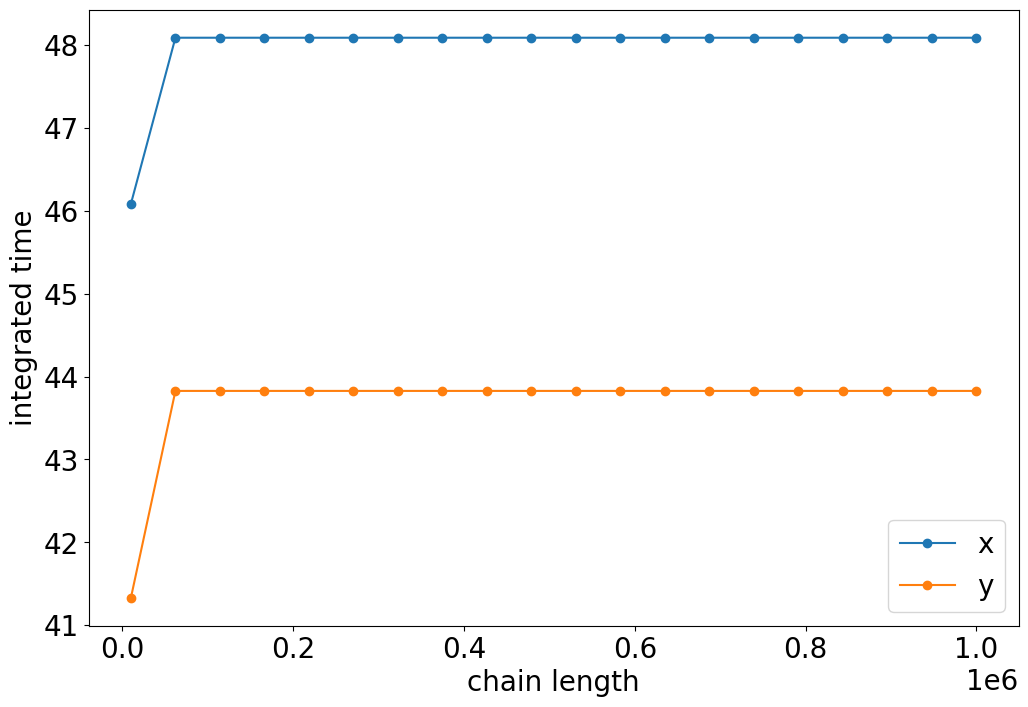

In [18]:
plt.figure(figsize = (12, 8))
plt.plot(chain_lengths, integrated_times[:,0] , 'o-', label = 'x')
plt.plot(chain_lengths, integrated_times[:,1] , 'o-', label = 'y')
# plt.plot(chain_lengths, chain_lengths / 50.0)
plt.legend()
plt.xlabel('chain length'), plt.ylabel('integrated time')
plt.savefig('chain_lengths.png')#, fmt='png')
plt.show()

## NESTED SAMPLING:

Define a uniform prior, using the same lower and upper bounds as for MCMC:

In [19]:
def nested_prior(cube, x_min=x_lower, x_max=x_upper, y_min=y_lower, y_max=y_upper):
    """
    Prior that is uniform 1 over x = (-5, 5), y = (-5, 5) and 0 outside of that range
    params are x, y
    
    Transforms uniform unit cube to cube defined by x and y above
    """

    cube[0] = cube[0] * (x_upper - x_lower) + x_lower  # transforms [0, 1] unit cube to [x_lower, x_upper] uniform
    cube[1] = cube[1] * (y_upper - y_lower) + y_lower  # transforms [0, 1] unit cube to [y_lower, y_upper] uniform
    
    return cube

Set up the nested sampler:

In [20]:
params = ['x', 'y']
n_params = len(params)

Run PyMultiNest:

In [21]:
# change this to whatever folder you want to save the chains to!
prefix = "chains/nested-"

# run the pymultinest

result = pymultinest.solve(LogLikelihood=log_likelihood, Prior=nested_prior, n_dims=n_params, 
                           n_live_points=int(1e5), evidence_tolerance=0.1, outputfiles_basename=prefix, verbose=True)
# pymultinest.run()

  analysing data from chains/nested-.txt


Loading the data:

In [22]:
prefix = 'chains/nested-'

post_equal_weights = np.loadtxt(f'{prefix}post_equal_weights.dat')
res = np.loadtxt(f'{prefix}.txt')
# stats = np.loadtxt(f'{prefix}stats.dat')

Plotting the posterior weight as a function of iteration to check for convergence:

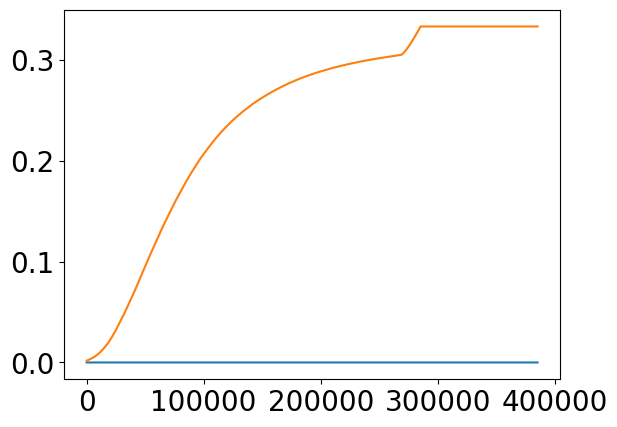

In [23]:
plt.plot(res[:,0])
plt.plot(np.exp(res[:,1]/-2))
plt.show()

In [24]:
res[:,0][-1], np.max(res[:,0])

(1.279210372269146e-06, 5.123235161591047e-06)

Plotting $2$-D histogram of the sampled distribution:

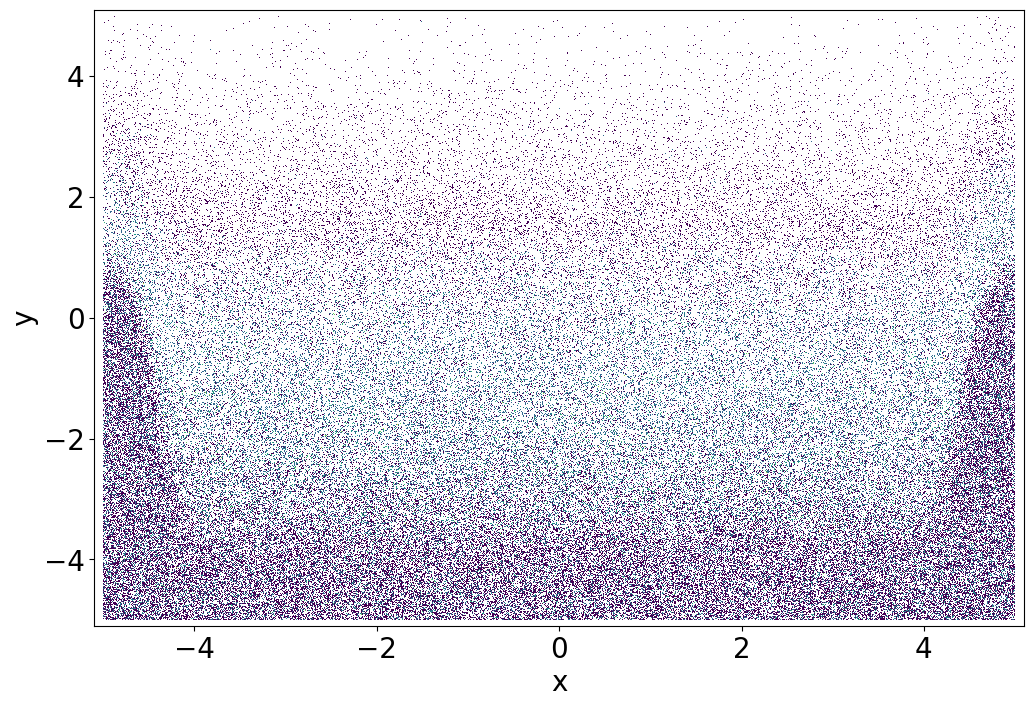

In [25]:
plt.figure(figsize = (12, 8))
# corner.hist2d(result['samples'][:,0], result['samples'][:,1], s=0.1, 
#               plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r')
plt.hist2d(post_equal_weights[:,0], post_equal_weights[:,1], norm = LogNorm(), bins=1000)
plt.xlabel('x'), plt.ylabel('y')
plt.xlim(left=-5.1, right=5.1)
plt.ylim(top=5.1, bottom=-5.1)
# cb = plt.colorbar()
plt.savefig('u_plot_nested_histogram.png')#, fmt='png')
plt.show()

and the contours:

Removed no burn in


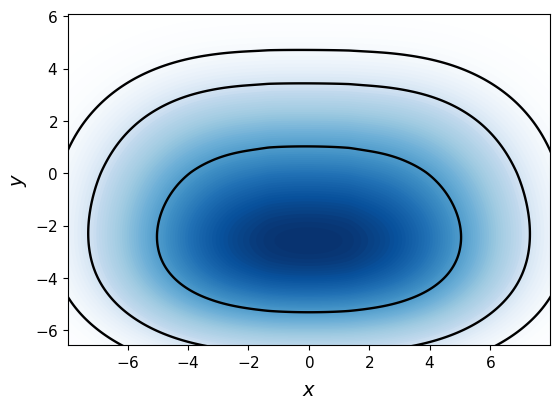

In [26]:
# convert samples to mcsamples object for getdist plotting
# samples = MCSamples(samples=result['samples'], names=['x', 'y'], labels=['x', 'y'])
samples = MCSamples(samples=post_equal_weights[:,:2], names=['x', 'y'], labels=['x', 'y'])

# Filled 2D comparison plot with legend
g = plots.get_single_plotter(width_inch=6)
samples.updateSettings({'contours': [0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 3

# plotting
g.plot_2d(samples, 'x', 'y', shaded=True)
plt.savefig('u_plot_nested_contours.png')#, fmt='png')
plt.show()

MCMC and nested sampling contours over the original function:

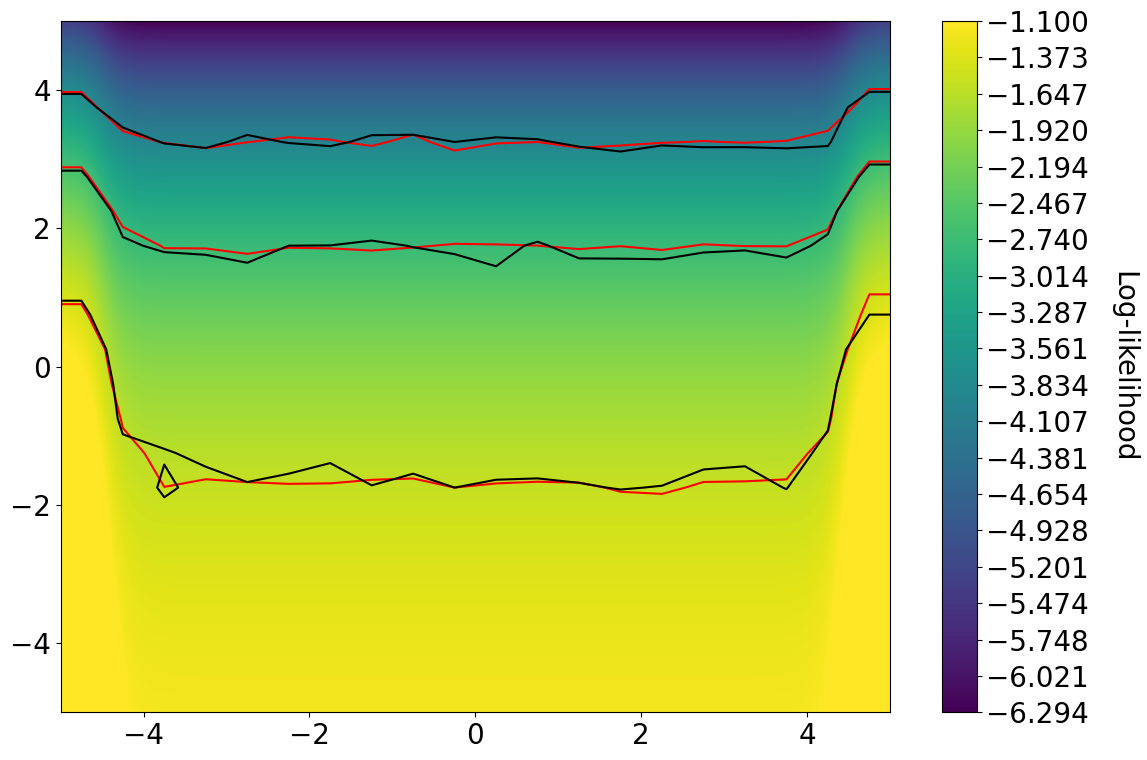

In [27]:
plt.figure(figsize = (12, 8))

# MCMC
corner.hist2d(x_samples.reshape(-1), y_samples.reshape(-1), s=0.1,
              plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r', label = 'MCMC')

# Nested Sampling
corner.hist2d(post_equal_weights[:,0], post_equal_weights[:,1], s=0.1,
              plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='k', label = 'nested')
# plt.legend()
plt.contourf(X, Y, testarr, levels=np.linspace(contour_min, contour_max, npoints), cmap='viridis')
cb = plt.colorbar()
# cb.formatter = LogFormatterExponent(base=10)
# this goes from ~ -50 to 0
cb.set_ticks(np.linspace(contour_min, contour_max, 20))#, update_ticks=True)
cb.set_label('Log-likelihood', rotation=270, labelpad = 35)

# fig = plt.contour(X, Y, testarr, levels=np.linspace(contour_min, contour_max, 50), colors='r')

# plt.contour(X, Y, testarr, levels = [np.max(testarr) + (0.68 * np.max(testarr))], colors='orange')

# pretty close to ~-3.9, -2.75, -1.6 here eyeballing
# fig = plt.contour(X, Y, testarr, levels=[-3.9, -2.75, -1.6], colors='orange')

plt.clabel(fig, inline=True, fontsize=10)
plt.tight_layout()

plt.savefig('mcmc_nested_contours.png')#, fmt='png')
plt.show()